# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [X] Explore the data
    - [X] get to know the master dataset
    - [X] feature engineering
- [X] Modeling
    - [X] create, fit, use XGBoost
    - [X] gridsearch
    - [X] retrain model using best hyperparameters
    - [X] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro

# For data preparation
from sklearn.model_selection import train_test_split

# For modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import pickle

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05

In [5]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [6]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

## ACQUIRE DATA

In [10]:
# Get the combined PEIMS and STAAR datasets
df = pd.read_csv('../data/inter/clean_2019.csv')

In [11]:
df.head()

,State Compensatory Education,Instructional Resource Media,Transportation,Curriculum/Staff Development,Extracurricular,Other Operating,Bilingual Program,Security & Monitoring,Other Uses,Pre-K,High School Allotment,Guidance & Counseling,General Administration,Food Service,Health Services,Professional & Contracted,Efficient
0,273747,66490,293070,4986,413755,809559,9599,0,48633,32890,40285,998314,284553,287406,37882,1075904,0
1,69915588,1585886,32321948,9927708,9898476,9454304,11437734,7816390,801985,19592708,5319962,27624583,15115454,45130399,5910337,51992341,0
2,2660496,333359,1406268,452741,1298174,838431,228663,219764,1375788,304299,581251,1069885,1047429,2131027,347775,2788430,0
3,799037,117860,422887,33175,598484,303052,0,13530,102465,0,101243,202086,558948,630202,33657,1514689,0
4,57183458,5383406,18036658,10842764,9783351,7036995,13027250,7063105,0,2451253,3233671,21683603,8567583,28485172,7124220,25806707,0


## PREPARATION

In [12]:
X = df.drop("Efficient", axis=1)
y = df['Efficient']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493, stratify=y)

## MODELING

In [14]:
# Init classifier
xgb_cl = xgb.XGBClassifier(random_state=493)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=493,
              reg_alpha=0, reg_lambda=1, ...)

0.78125

In [15]:
# make predictions for test data
y_pred = xgb_cl.predict(X_test)
predictions = [round(value) for value in y_pred]

In [16]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.12%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

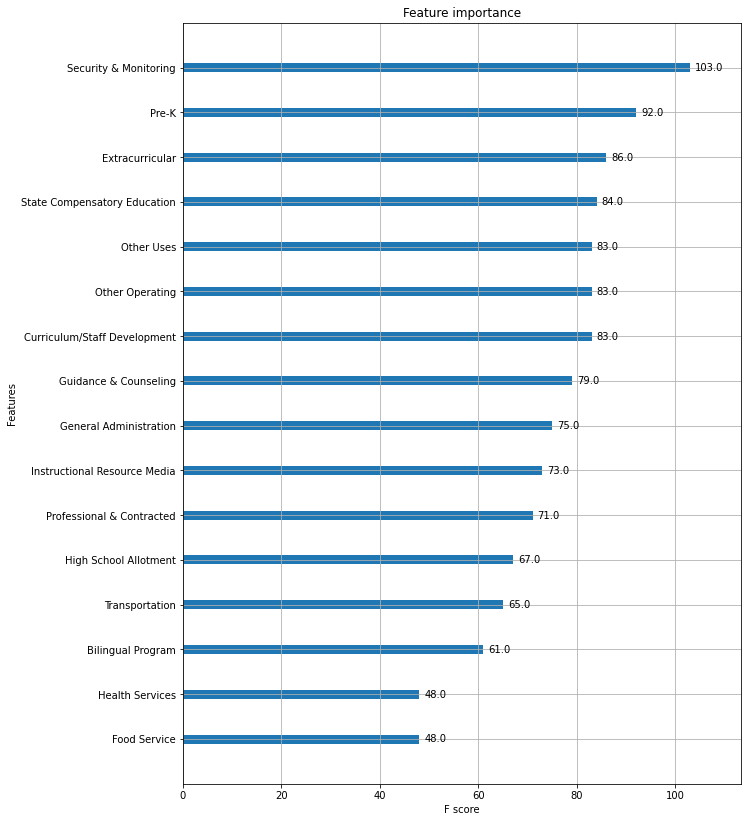

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10, 14))
plot_importance(booster=xgb_cl, ax=ax)

In [18]:
rocauc = roc_auc_score(y, xgb_cl.predict_proba(X)[:, 1])
print("ROC AUC Score (No Skill): %.2f%%" % (.5 * 100.0))
print("ROC AUC Score (Skilled ): %.2f%%" % (rocauc * 100.0))

ROC AUC Score (No Skill): 50.00%
ROC AUC Score (Skilled ): 93.26%


Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

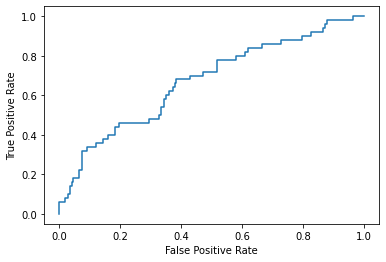

In [19]:
y_pred_proba = xgb_cl.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
# save the model to disk
pickle.dump(xgb_cl, open('../models/final_model.sav', 'wb'))